In [3]:
import random
from typing import Annotated, Literal

from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages


class State(TypedDict):
    messages: Annotated[list, add_messages]


class MyNode: # Node in LangGraph outputs to-be-changed values in the state
    def __init__(self, name: str):
        self.name = name

    def __call__(self, state: State): # here, only the message will be changed in the state
        return {"messages": [("assistant", f"Called node {self.name}")]}


def route(state) -> Literal["entry_node", "__end__"]: # Decide whether to end the graph
    if len(state["messages"]) > 10:
        return "__end__"
    return "entry_node"


def add_fractal_nodes(builder, current_node, level, max_level):
    if level > max_level:
        return

    # Number of nodes to create at this level
    num_nodes = random.randint(1, 3)  # Adjust randomness as needed
    for i in range(num_nodes):
        nm = ["A", "B", "C"][i]
        node_name = f"node_{current_node}_{nm}"
        builder.add_node(node_name, MyNode(node_name))
        builder.add_edge(current_node, node_name)

        # Recursively add more nodes
        r = random.random()
        if r > 0.2 and level + 1 < max_level:
            add_fractal_nodes(builder, node_name, level + 1, max_level)
        elif r > 0.05:
            builder.add_conditional_edges(node_name, route, node_name)
        else:
            # End
            builder.add_edge(node_name, "__end__")


def build_fractal_graph(max_level: int):
    builder = StateGraph(State)
    entry_point = "entry_node"
    builder.add_node(entry_point, MyNode(entry_point))
    builder.add_edge(START, entry_point)

    add_fractal_nodes(builder, entry_point, 1, max_level)

    # Optional: set a finish point if required
    builder.add_edge(entry_point, END)  # or any specific node

    return builder.compile()


app = build_fractal_graph(3)

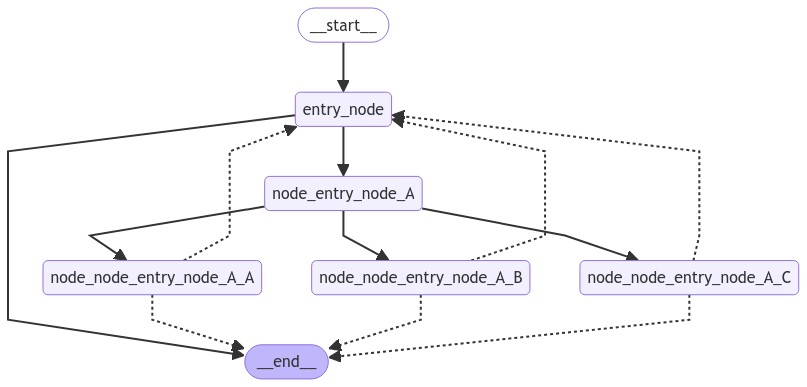

In [4]:
from IPython.display import Image, display
from langchain_core.runnables.graph import CurveStyle, MermaidDrawMethod, NodeStyles

display(
    Image(
        app.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API,
        )
    )
)

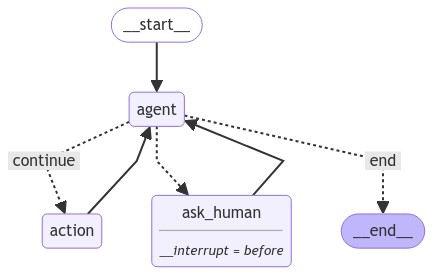

In [8]:
# Set up the state
from langgraph.graph import MessagesState, START

# Set up the tool
# We will have one real tool - a search tool
# We'll also have one "fake" tool - a "ask_human" tool
# Here we define any ACTUAL tools
from langchain_core.tools import tool
from langgraph.prebuilt import ToolNode


@tool
def search(query: str):
    """Call to surf the web."""
    # This is a placeholder for the actual implementation
    # Don't let the LLM know this though 😊
    return [
        f"I looked up: {query}. Result: It's sunny in San Francisco, but you better look out if you're a Gemini 😈."
    ]


tools = [search]
tool_node = ToolNode(tools)

# Set up the model
from langchain_anthropic import ChatAnthropic
from langchain_openai import ChatOpenAI

model = ChatAnthropic(model="claude-3-5-sonnet-20240620")
model = ChatOpenAI(model="gpt-4o")

# We are going "bind" all tools to the model
# We have the ACTUAL tools from above, but we also need a mock tool to ask a human
# Since `bind_tools` takes in tools but also just tool definitions,
# We can define a tool definition for `ask_human`

from langchain_core.pydantic_v1 import BaseModel


class AskHuman(BaseModel):
    """Ask the human a question"""

    question: str


model = model.bind_tools(tools + [AskHuman])

# Define nodes and conditional edges

from langchain_core.messages import ToolMessage

from langgraph.prebuilt import ToolInvocation


# Define the function that determines whether to continue or not
def should_continue(state):
    messages = state["messages"]
    last_message = messages[-1]
    # If there is no function call, then we finish
    if not last_message.tool_calls:
        return "end"
    # If tool call is asking Human, we return that node
    # You could also add logic here to let some system know that there's something that requires Human input
    # For example, send a slack message, etc
    elif last_message.tool_calls[0]["name"] == "AskHuman":
        return "ask_human"
    # Otherwise if there is, we continue
    else:
        return "continue"


# Define the function that calls the model
def call_model(state):
    messages = state["messages"]
    response = model.invoke(messages)
    # We return a list, because this will get added to the existing list
    return {"messages": [response]}


# We define a fake node to ask the human
def ask_human(state):
    pass


# Build the graph

from langgraph.graph import END, StateGraph

# Define a new graph
workflow = StateGraph(MessagesState)

# Define the three nodes we will cycle between
workflow.add_node("agent", call_model)
workflow.add_node("action", tool_node)
workflow.add_node("ask_human", ask_human)

# Set the entrypoint as `agent`
# This means that this node is the first one called
workflow.add_edge(START, "agent")

# We now add a conditional edge
workflow.add_conditional_edges(
    # First, we define the start node. We use `agent`.
    # This means these are the edges taken after the `agent` node is called.
    "agent",
    # Next, we pass in the function that will determine which node is called next.
    should_continue,
    # Finally we pass in a mapping.
    # The keys are strings, and the values are other nodes.
    # END is a special node marking that the graph should finish.
    # What will happen is we will call `should_continue`, and then the output of that
    # will be matched against the keys in this mapping.
    # Based on which one it matches, that node will then be called.
    {
        # If `tools`, then we call the tool node.
        "continue": "action",
        # We may ask the human
        "ask_human": "ask_human",
        # Otherwise we finish.
        "end": END,
    },
)

# We now add a normal edge from `tools` to `agent`.
# This means that after `tools` is called, `agent` node is called next.
workflow.add_edge("action", "agent")

# After we get back the human response, we go back to the agent
workflow.add_edge("ask_human", "agent")

# Set up memory
from langgraph.checkpoint.memory import MemorySaver

memory = MemorySaver()

# Finally, we compile it!
# This compiles it into a LangChain Runnable,
# meaning you can use it as you would any other runnable
# We add a breakpoint BEFORE the `ask_human` node so it never executes
app = workflow.compile(checkpointer=memory, interrupt_before=["ask_human"])

display(Image(app.get_graph().draw_mermaid_png()))

In [9]:
from langchain_core.messages import HumanMessage

config = {"configurable": {"thread_id": "2"}}
input_message = HumanMessage(
    content="Use the search tool to ask the user where they are, then look up the weather there"
)
for event in app.stream({"messages": [input_message]}, config, stream_mode="values"):
    event["messages"][-1].pretty_print()

================================ Human Message =================================

Use the search tool to ask the user where they are, then look up the weather there
================================== Ai Message ==================================
Tool Calls:
  AskHuman (call_qp0BSh4c9JGMqiCLa9lqzeR3)
 Call ID: call_qp0BSh4c9JGMqiCLa9lqzeR3
  Args:
    question: Where are you currently located?


In [10]:
tool_call_id = app.get_state(config).values["messages"][-1].tool_calls[0]["id"]

# We now create the tool call with the id and the response we want
tool_message = [
    {"tool_call_id": tool_call_id, "type": "tool", "content": "san francisco"}
]

# # This is equivalent to the below, either one works
# from langchain_core.messages import ToolMessage
# tool_message = [ToolMessage(tool_call_id=tool_call_id, content="san francisco")]

# We now update the state
# Notice that we are also specifying `as_node="ask_human"`
# This will apply this update as this node,
# which will make it so that afterwards it continues as normal
app.update_state(config, {"messages": tool_message}, as_node="ask_human")

# We can check the state
# We can see that the state currently has the `agent` node next
# This is based on how we define our graph,
# where after the `ask_human` node goes (which we just triggered)
# there is an edge to the `agent` node
app.get_state(config).next

('agent',)

In [11]:
for event in app.stream(None, config, stream_mode="values"):
    event["messages"][-1].pretty_print()

================================== Ai Message ==================================
Tool Calls:
  search (call_DVUs7CpCRvS7R4YP9CB45w1G)
 Call ID: call_DVUs7CpCRvS7R4YP9CB45w1G
  Args:
    query: current weather in San Francisco
================================= Tool Message =================================
Name: search

["I looked up: current weather in San Francisco. Result: It's sunny in San Francisco, but you better look out if you're a Gemini \ud83d\ude08."]
================================== Ai Message ==================================

The current weather in San Francisco is sunny. Enjoy the sunshine! 🌞
